In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

import sklearn.metrics as sklm

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [11]:

#import data
os.chdir("/Users/hubertjenq/kaggle/sberbank russian housing")
train_df = pd.read_csv("train.csv",parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv",parse_dates=['timestamp'])

#use only macroeconomic columns from the macro data
macroecon_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]
macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macroecon_cols)

# Data Quality Changes

In [12]:
#fix wrong state to the most occured state
train_df.loc[train_df['state'] == 33, 'state'] = train_df['state'].mode().iloc[0]

#fix build year errors
train_df[train_df['build_year']==0]['build_year']=np.nan
train_df[train_df['build_year']==1]['build_year']=np.nan
train_df[train_df['build_year']==3]['build_year']=np.nan
train_df[train_df['build_year']==4965]['build_year']=np.nan
train_df[train_df['build_year']==71]['build_year']=np.nan

In [13]:
train_df['build_year']=train_df['build_year'].replace(215,2015)
train_df['build_year']=train_df['build_year'].replace(20052009,2005)
train_df['build_year']=train_df['build_year'].replace(20,2000)

# Merge test/train to make change/make new features

In [14]:
#Make a data frame with all the data in it

#count test/train data
num_train=train_df.shape[0]
num_test=train_df.shape[0]

#save id and price of the train/test 
train_id=train_df['id']
train_logprice=np.log1p(train_df['price_doc'].values)
test_id=test_df['id']

#drop id/price
train_df.drop(['id','price_doc'],axis=1,inplace=True)
test_df.drop(['id'],axis=1,inplace=True)

#Combine test/train and the macro data by timestamp
all_df = pd.concat([train_df,test_df])
all_df = pd.merge_ordered(all_df,macro_df,on='timestamp',how='left')
all_df.head()


,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

# Make new features/remove some

In [15]:
#Convert timestamp to year, month, day of week, and date 
all_df['yearsale']=pd.DatetimeIndex(all_df['timestamp']).year
all_df['monthsale']=pd.DatetimeIndex(all_df['timestamp']).month
all_df['dayofweeksale']=pd.DatetimeIndex(all_df['timestamp']).weekday
all_df['dateofsale']=pd.DatetimeIndex(all_df['timestamp']).day


In [16]:
#add houseage
all_df['houseage']=2020-all_df['build_year']

In [17]:
#add number of floors from top
all_df['floorsfromtop']=all_df['max_floor']-all_df['floor'].astype(float)
#relative floors
all_df['relativefloor']=all_df['floor']/all_df['max_floor'].astype(float)
#add average room size
all_df['avgroomsize']=all_df['full_sq']/all_df['num_room'].astype(float)
#add kitchen size percentage of house
all_df['kitchenpercentage']=all_df['kitch_sq']/all_df['full_sq'].astype(float)

#drop timestamp
all_df.drop(['timestamp'],inplace=True,axis=1)

In [18]:
all_df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_pr

In [19]:
all_obj_df=all_df.select_dtypes(include=['object']).copy()
all_num_df=all_df.select_dtypes(exclude=['object'])

knnxval_df = pd.read_csv("knnxvalues.csv")
all_num_df=knnxval_df

#Change catagorical variables to factors

for o in all_obj_df:
    all_obj_df[o] = pd.factorize(all_obj_df[o])[0]

#put categorical and numeric variables back together
all_df_values=pd.concat([all_num_df,all_obj_df],axis=1)

#convert to numeric values
all_x = all_df_values.values

colnames=all_df.columns

In [20]:
#split all data back into test/training

train_x = all_x[:num_train]
test_x = all_x[num_train:]

#choose 7626 training and 30507 test
indices = np.random.permutation(train_x.shape[0])
valind = indices[:7626]
trainind = indices[7626:]

val_x = train_x[valind]
trainmod_x = train_x[trainind]
val_y = train_logprice[valind]
trainmod_y = train_logprice[trainind]



In [21]:
#Convert the data to xgb matrices

xgbfulltrain=xgb.DMatrix(train_x,train_logprice,feature_names=colnames)
xgbtrain=xgb.DMatrix(trainmod_x,trainmod_y,feature_names=colnames)
xgbval=xgb.DMatrix(val_x,val_y,feature_names=colnames)
xgbtest=xgb.DMatrix(test_x,feature_names=colnames)

# Find optimal number of boosting Rounds

In [22]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

partial_model = xgb.train(xgb_params, xgbtrain, num_boost_round=1000, evals=[(xgbval, 'eval')],early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	eval-rmse:14.359
Will train until eval-rmse hasn't improved in 20 rounds.
[20]	eval-rmse:5.16801
[40]	eval-rmse:1.90693
[60]	eval-rmse:0.8144
[80]	eval-rmse:0.528133
[100]	eval-rmse:0.47691
[120]	eval-rmse:0.468588
[140]	eval-rmse:0.466926
[160]	eval-rmse:0.465706
[180]	eval-rmse:0.465143
[200]	eval-rmse:0.464883
[220]	eval-rmse:0.464138
[240]	eval-rmse:0.463945
[260]	eval-rmse:0.463303
[280]	eval-rmse:0.462855
Stopping. Best iteration:
[277]	eval-rmse:0.462819



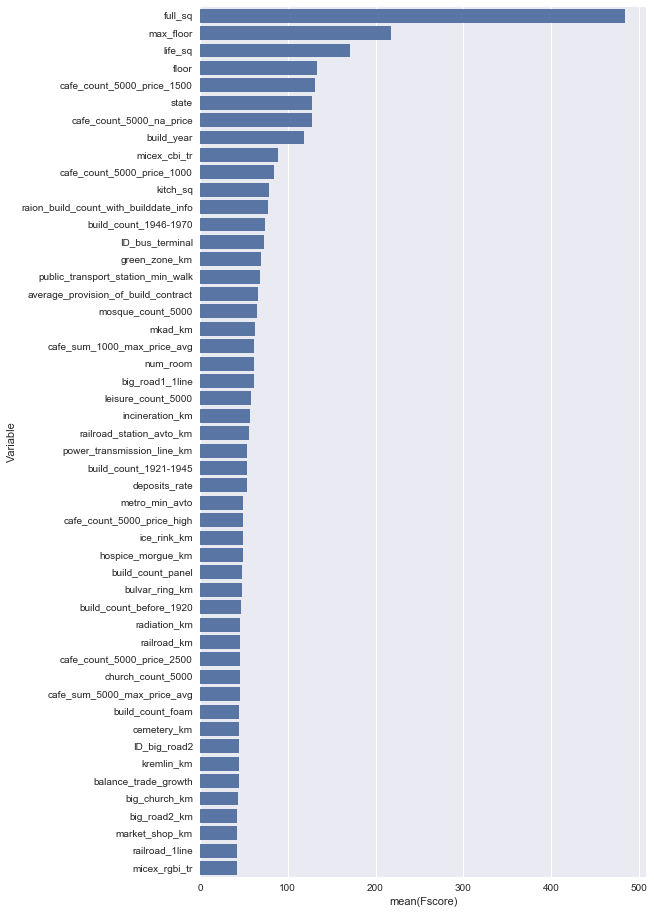

In [23]:
importance = partial_model.get_fscore()
VariableImpDf=pd.DataFrame(list(importance.items()),columns=['Variable','Fscore'])
SortedVIDf=VariableImpDf.sort_values('Fscore',ascending=False)
fig=plt.figure(figsize=(8,16))
sns.barplot(SortedVIDf.Fscore[0:50],SortedVIDf.Variable[0:50],color=color[0])

In [24]:
model = xgb.train(dict(xgb_params, silent=0), xgbfulltrain , num_boost_round=num_boost_round)

In [25]:
ylog_pred = model.predict(xgbtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)


# Hyperparameter optimization

In [ ]:
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000,1),
             'max_depth': 5,
             'eta' : hp.uniform('eta', 0.001, 0.5),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 7,1),
             'subsample' : hp.quniform('subsample', 0.5, 1,.05),
             'gamma' : hp.quniform('gamma', 0.05, 1,0.025),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.025),
             'objective': 'reg:linear',
             'eval_metric': 'rmse',
             'silent' : 0,
             'lambda' : hp.quniform('lambda',0,1,.015),
             'alpha' : hp.quniform('alpha',0,1,.015)
             }



In [ ]:
def score(params):
    boost_rounds=int(params['n_estimators'])
    model = xgb.train(params, xgbtrain, num_boost_round=boost_rounds)
    del params['n_estimators']
    
    predictions = model.predict(xgbval)
    yval=xgbval.get_label()
    score = np.sqrt(sklm.mean_squared_error(yval, predictions))
    print("\tObjective {0}\n\n".format(score))
    
    return {'loss': score, 'status': STATUS_OK}

In [ ]:
trials = Trials()

In [ ]:
trials = Trials()
best = fmin(fn=score, space=space, algo=tpe.suggest, trials=trials, max_evals=2000)

In [ ]:
model = xgb.train(best, xgbfulltrain, num_boost_round=int(best['n_estimators']))
np.sqrt(sklm.mean_squared_error(yval, model.predict(xgbval)))

In [ ]:
best

In [ ]:
model.attributes()

In [ ]:
best={'alpha': 0.615,
   'colsample_bytree': 0.525,
   'eta': 0.012712929939504953,
   'gamma': 0.9750000000000001,
   'lambda': 0.6749999999999999,
   'min_child_weight': 7.0,
   'n_estimators': 979,
   'subsample': 0.8500000000000001}

In [ ]:
values=[trials.results[x]['loss'] for x in range(0,len(trials.results))]

In [ ]:
values=[]
for x in range(0,(984)):
    values.append(trials.results[x]['loss'])

In [ ]:

trials.trials[values.index(min(values))]

In [ ]:
ylog_pred = model.predict(xgbtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)


In [ ]:
fasdklfadjsl;